In [1]:
import os
data_dir = 'C:/Users/pongsasit/Desktop/code/jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')


f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


#parsing the data
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

In [3]:
def generator(data_1, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+ batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback//step,
                           data_1.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data_1[indices]
            targets[j] = data_1[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

In [4]:
#data_1 = original array
#lookback = how many timestep that we want to look back
#delay = how many timesteps in the future the target should be
#min_index max_index indice the data_1 array 
#shuffle draw data in chronological order
#batch_size = the number of samples per batch
#step= period
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [5]:
#train, validation, test
train_gen = generator(float_data,lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size= batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index = 300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=300001,
                   max_index = None,
                   step=step,
                   batch_size=batch_size)

val_steps = (300000-200001-lookback) // batch_size
test_steps =(len(float_data)-300001-lookback)//batch_size

In [6]:
#Training and evaluating a simple 1D convnet on the Jena data
from keras.models import Sequential
from keras import layers
from keras.layers import Conv1D
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                       input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(),loss = 'mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for upd

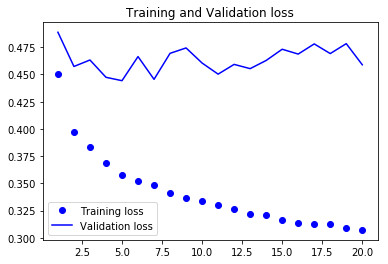

In [8]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [11]:
#higher-resolution
#preparing higher-resolution data generators for the Jena dataset
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index = 300000,
                   step=step)
test_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=300001,
                   max_index = None,
                   step=step)

val_steps = (300000-200001-lookback) // batch_size
test_steps =(len(float_data)-300001-lookback)//batch_size

In [12]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv1D
from keras.optimizers import RMSprop

model_GRU = Sequential()
model_GRU.add(layers.Conv1D(32, 5, activation='relu',
                           input_shape=(None, float_data.shape[-1])))
model_GRU.add(layers.MaxPooling1D(3))
model_GRU.add(layers.Conv1D(32, 5, activation='relu'))
model_GRU.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(),loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 7,457
Trainab

C:\Users\pongsasit\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/20
500/500 [==============================] - 42s 85ms/step - loss: 0.4158 - val_loss: 0.4324
Epoch 2/20
500/500 [==============================] - 42s 83ms/step - loss: 0.3769 - val_loss: 0.4475
Epoch 3/20
500/500 [==============================] - 42s 84ms/step - loss: 0.3606 - val_loss: 0.4592
Epoch 4/20
500/500 [==============================] - 42s 83ms/step - loss: 0.3519 - val_loss: 0.4568
Epoch 5/20
500/500 [==============================] - 42s 84ms/step - loss: 0.3405 - val_loss: 0.4547
Epoch 6/20
500/500 [==============================] - 42s 83ms/step - loss: 0.3359 - val_loss: 0.4729
Epoch 7/20
500/500 [==============================] - 42s 83ms/step - loss: 0.3316 - val_loss: 0.4634
Epoch 8/20
500/500 [==============================] - 42s 83ms/step - loss: 0.3263 - val_loss: 0.4668
Epoch 9/20
500/500 [==============================] - 42s 84ms/step - loss: 0.3236 - val_loss: 0.4796
Epoch 10/20
500/500 [==============================] - 42s 84ms/step - loss: 0.319

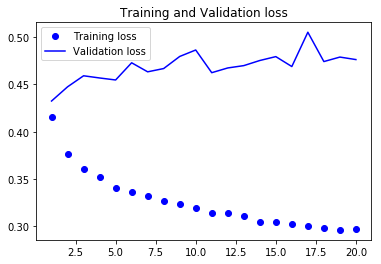

In [13]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
#FASTER than using pure GRU but more loss